# Correlation Exercises

- Use the telco_churn data. Does tenure correlate with monthly charges? Total charges? What happens if you control for phone and internet service?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pydataset
import matplotlib.pyplot as plt
import seaborn as sns
import env

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/telco_churn'
    
pd.options.display.max_columns = None

In [2]:
sql_query = '''SELECT *
               FROM customers
               JOIN internet_service_types USING (internet_service_type_id)'''

In [3]:
df = pd.read_sql(sql_query, url)

In [4]:
df.head()

,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type
0,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,Fiber optic
3,2,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,Fiber optic
4,2,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,Fiber optic


In [5]:
df.columns

Index(['internet_service_type_id', 'customer_id', 'gender', 'senior_citizen',
       'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'internet_service_type'],
      dtype='object')

In [6]:
df = df[['tenure', 'monthly_charges', 'total_charges', 'internet_service_type', 'phone_service']]

In [7]:
df.sort_values(by='total_charges').head()

,tenure,monthly_charges,total_charges,internet_service_type,phone_service
2855,0,73.35,,DSL,Yes
3118,0,52.55,,DSL,No
3052,0,25.75,,None,Yes
5433,0,19.85,,None,Yes
1731,0,20.00,,None,Yes


In [8]:
df.total_charges.value_counts() # whitespace characters used as null values

20.2       11
           11
19.75       9
19.65       8
20.05       8
           ..
620.75      1
824.85      1
1476.25     1
140.95      1
390.4       1
Name: total_charges, Length: 6531, dtype: int64

In [9]:
df.total_charges = df.total_charges.replace(' ', np.nan).astype(float)

In [10]:
df.info() # several null values in total charges

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tenure                 7043 non-null   int64  
 1   monthly_charges        7043 non-null   float64
 2   total_charges          7032 non-null   float64
 3   internet_service_type  7043 non-null   object 
 4   phone_service          7043 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 275.2+ KB


In [11]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tenure                 7032 non-null   int64  
 1   monthly_charges        7032 non-null   float64
 2   total_charges          7032 non-null   float64
 3   internet_service_type  7032 non-null   object 
 4   phone_service          7032 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 329.6+ KB


#### Tenure vs. Monthly Charges

${H_0}$: There is no **linear** relationship between tenure and monthly charges

${H_a}$: There is a **linear** relationship between tenure and monthly charges

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

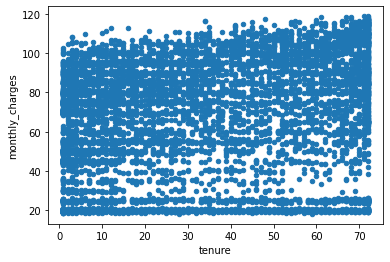

In [12]:
df.plot.scatter(y='monthly_charges', x='tenure')

In [13]:
alpha = 0.05

In [14]:
r, p = stats.pearsonr(df.tenure, df.monthly_charges)
r, p

(0.2468617666408935, 3.9898213232673846e-98)

In [15]:
if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


We reject the null hypothesis, but while there is a weak-moderate relationship between tenure and monthly charges, there are two relationships apparent on visual inspection:
- A rising channel ranging from 0-100 at t=0 and ranging from 35-120 at t=end
- Two horizontal bands for customers paying ~$20 and ~$25
- Overall, r & p scores demonstrate a weak positive correlation, but the magnitude of the relationship is relatively small

#### Tenure vs. Total Charges

${H_0}$: There is no **linear** relationship between tenure and total charges.

${H_a}$: There is a **linear** relationship between tenure and total charges.

<AxesSubplot:xlabel='tenure', ylabel='total_charges'>

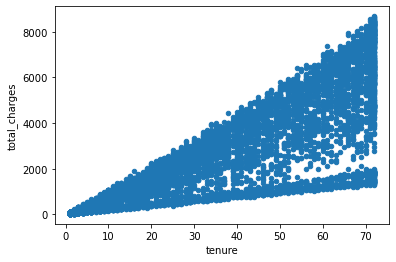

In [16]:
df.plot.scatter(y='total_charges', x='tenure')

In [17]:
stats.pearsonr(df.tenure, df.total_charges)

(0.825880460933202, 0.0)

We reject the null hypothesis. There is a strong correlation between tenure and total charges. Significant heteroscedasticity is present on visual observation. Thus, a linear relationship, though technically present, may be limited in its ability to predict total charges at high tenure. 

The relationship is reasonable, given that a customer will always pay the company more in total charges over time. 

### Controlling for Phone and Internet Services

Lets look at how subsets for phone and internet services relate monthly charges and tenure.

In [18]:
def corr_tenure_and_monthly(df):
    return pd.Series(stats.pearsonr(df.tenure, df.monthly_charges), index = ['r', 'p'])

In [19]:
# Do stuff faster with this ONE TRICK stakeholders hate!
df.groupby(['internet_service_type', 'phone_service']).apply(corr_tenure_and_monthly)

r              p
internet_service_type phone_service                         
DSL                   No             0.592430   1.173274e-65
                      Yes            0.658094  5.781402e-216
Fiber optic           Yes            0.624621   0.000000e+00
None                  Yes            0.346188   4.896605e-44

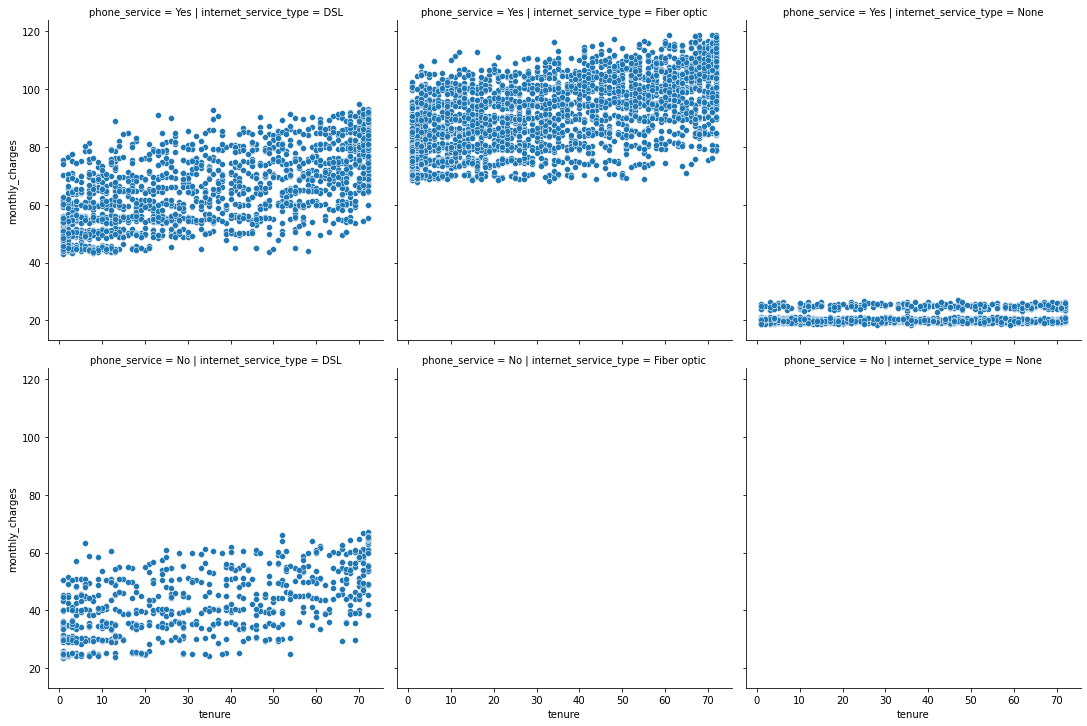

In [20]:
sns.relplot(data=df, y='monthly_charges', x='tenure', col='internet_service_type', row='phone_service')

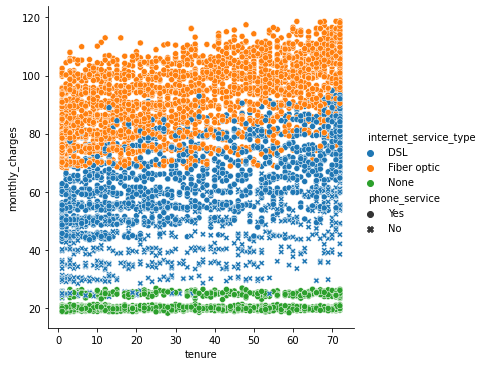

In [21]:
# You could cram it all into one visual if you wanted to...
sns.relplot(data=df, y='monthly_charges', x='tenure', hue='internet_service_type', style='phone_service')

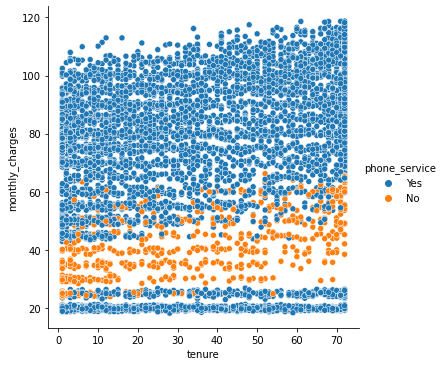

In [22]:
sns.relplot(data=df, y='monthly_charges', x='tenure', hue='phone_service')

Now lets look at how these same subsets relate total charges and tenure

In [23]:
def corr_tenure_and_total(df):
    return pd.Series(stats.pearsonr(df.tenure, df.total_charges), index=['r', 'p'])

In [24]:
df.groupby(['internet_service_type', 'phone_service']).apply(corr_tenure_and_total)

r    p
internet_service_type phone_service               
DSL                   No             0.953423  0.0
                      Yes            0.970533  0.0
Fiber optic           Yes            0.985309  0.0
None                  Yes            0.981465  0.0

Compare these results to the overall result:

In [25]:
stats.pearsonr(df.tenure, df.total_charges)

(0.825880460933202, 0.0)

How can it be that individual correlations can be stronger than the overall correlation?

### Employees Analysis (Question Part 2)
Use the employees database.
- Is there a relationship between how long an employee has been with the company and their salary?
- Is there a relationship between how long an employee has been with the company and the number of titles they have had?

In [26]:
# How you define the range of dates you will consider using will have an effect
# Given that this dataset is outdated, you can use your best reasonable approach to define a meaningful range of dates
# For this demo, we will just go with a very simple approach of only considering current employees and pretending that the data is actually current
query = '''
SELECT
    DATEDIFF((SELECT MAX(hire_date) FROM employees), e.hire_date) AS tenure,
    s.salary AS salary
FROM employees e
JOIN salaries s USING (emp_no)
WHERE s.to_date > NOW()
'''

In [27]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/employees'

In [28]:
employees_with_salaries = pd.read_sql(query, url)

In [29]:
employees_with_salaries

,tenure,salary
0,4964,88958
1,5181,72527
2,4901,43311
3,4806,74057
4,3790,94692
...,...,...
240119,2572,52868
240120,3410,69501
240121,5030,83441
240122,2298,55003


${H_0}$: There is no linear relationship between employee tenure and their salary

${H_a}$: There is a linear relationship between employee tenure and their salary

In [30]:
stats.pearsonr(employees_with_salaries.tenure, employees_with_salaries.salary)

(0.3064625613186077, 0.0)

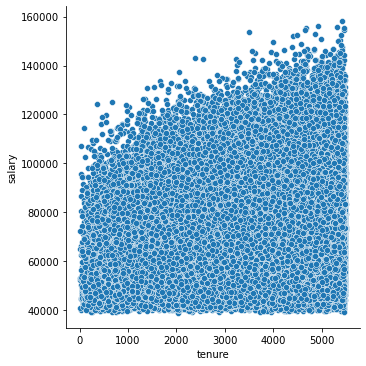

In [31]:
sns.relplot(data=employees_with_salaries, y='salary', x='tenure')

We can reject the null hypothesis, but the correlation is weak to moderate in the positive direction. Heteroscedasticity increases here as well, so if we took this correlation and used it as part of a linear regression for prediction, we would have a significant amount of potential error. 

In [32]:
query = '''
SELECT
    e.emp_no,
    DATEDIFF((SELECT MAX(hire_date) FROM employees), e.hire_date) AS tenure,
    n_titles
FROM employees e
JOIN (
    SELECT emp_no, COUNT(*) as n_titles
    FROM employees e
    JOIN titles t USING (emp_no)
    GROUP BY emp_no
) emp_title_count USING (emp_no)
'''

In [33]:
employees_with_titles = pd.read_sql(query, url)

In [34]:
employees_with_titles.shape

(300024, 3)

In [35]:
employees_with_titles.head()

,emp_no,tenure,n_titles
0,10001,4964,1
1,10002,5181,1
2,10003,4901,1
3,10004,4806,2
4,10005,3790,2


$H_0$: There's no linear relationship between employee tenure and number of titles

$H_a$: There's a linear relationship between employee tenure and number of titles

In [36]:
stats.pearsonr(employees_with_titles.tenure, employees_with_titles.n_titles)

(0.26659892991366185, 0.0)

We reject the null hypothesis

## Sleep Study

In [37]:
pydataset.data('sleepstudy', show_doc=True)

sleepstudy

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Reaction times in a sleep deprivation study

### Description

The average reaction time per day for subjects in a sleep deprivation study.
On day 0 the subjects had their normal amount of sleep. Starting that night
they were restricted to 3 hours of sleep per night. The observations represent
the average reaction time on a series of tests given each day to each subject.

### Format

A data frame with 180 observations on the following 3 variables.

`Reaction`

Average reaction time (ms)

`Days`

Number of days of sleep deprivation

`Subject`

Subject number on which the observation was made.

### Details

These data are from the study described in Belenky et al. (2003), for the
sleep-deprived group and for the first 10 days of the study, up to the
recovery period.

### References

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen
C. Sing, Daniel P. Redmond, 

In [38]:
sleep = pydataset.data('sleepstudy')
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


$H_0$: there is no linear relationship between reaction time and number of days

$H_a$: there is a linear relationship between reaction time and number of days

In [39]:
stats.pearsonr(sleep.Reaction, sleep.Days) # We reject the null hypothesis

(0.5352302262650253, 9.894096322214812e-15)

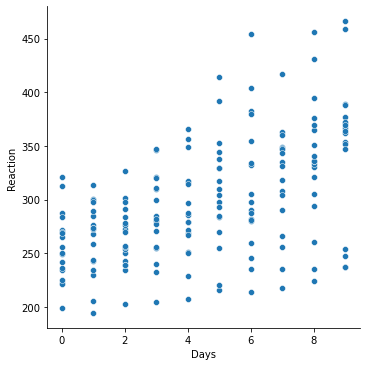

In [40]:
sns.relplot(data=sleep, y='Reaction', x='Days')